# Primena **hijerarhijskog sakupljajućeg  klasterovanja**
# na podatke o geografskoj lokaciji aerodroma

Sa dosadašnjim algoritmima nismo uspeli da postignemo najbolje rezultate.
Problem kod K-Means algoritma je bio što podaci nisu globularni. Ipak sa njime smo do sada postigli najbolje rezulate. Problem sa DBSCAN - algoritmom je zbog nejednake gustine podataka. Nadamo se da ćemo primenom hijerarhijskog sakupljajućeg klasterovanja postići bolje rezultate.

Kao i kod svih drugih algoritama, naš zadatak je da, u zavisnosti od podataka, prilagodimo parametre algoritma da bismo postigli sto bolje rezultate. Ovde imamo posebnu brigu o odabiru odgovarajućeg kriterijuma spajanja klastera. Kao sto iz vizuelizacije podataka možemo videti, ređi delovi su blizu veoma gustih, tako da već odatle možemo da zaključimo da minimalna (single) veza nije dobar izbor

## Neophodni importi

In [1]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

## Učitavanje podataka, upoznavanje sa njima i vizuelizacija

In [9]:
df = pd.read_csv('../Data/airports_PreprocessedData.csv')
whole_set = len(df)
df.head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source,Altitude_CATEGORY,Coord_X,Coord_Y,Coord_X_Nearest_End
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10.0,U,Pacific/Port_Moresby,airport,OurAirports,2,16158.656679,-675.910224,3840.837979
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10.0,U,Pacific/Port_Moresby,airport,OurAirports,1,16202.779039,-578.707337,3796.715620
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10.0,U,Pacific/Port_Moresby,airport,OurAirports,2,16036.849596,-647.581008,3962.645063
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10.0,U,Pacific/Port_Moresby,airport,OurAirports,1,16306.913146,-730.158416,3692.581512
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10.0,U,Pacific/Port_Moresby,airport,OurAirports,1,16361.818285,-1049.523652,3637.676374


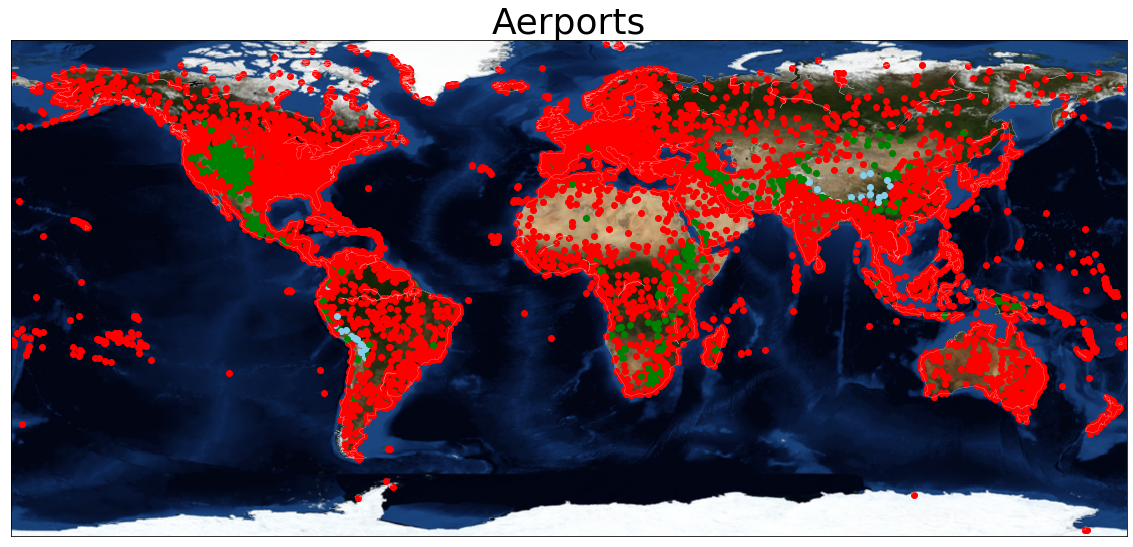

In [3]:
plt.rcParams["font.size"] = 30

fig = plt.gcf()
fig.set_size_inches(20, 20)

m = Basemap(projection='cyl', \
            llcrnrlat=-80, urcrnrlat=80, \
            llcrnrlon=-180, urcrnrlon=180, \
            lat_ts=20, \
            resolution='c')

m.bluemarble(scale=0.2)   # full scale will be overkill
m.drawcoastlines(color='white', linewidth=0.2)  # add coastlines

x, y = m(list(df['Longitude']),list(df['Latitude']))  # transform coordinates

colors = ['red','green','skyblue'] # Aerodrome bojimo na mapi u zavisnosti od visinske kategorije
category_altitude = list(df['Altitude_CATEGORY'])

plt.title("Aerports")
for i in range(0,len(x)):
    plt.scatter(x[i],y[i], color = colors[category_altitude[i] - 1])

plt.show()

## Preprocesiranje podataka
### Odabir karakteristika i skaliranje raspona svih atributa na interval $(0,1)$
Isto ćemo prvobitno vršiti klasterovanje u odnosu na atribute *Longitude*, *Latitude* i 
*Altitude* .

In [4]:
features = ['Longitude','Latitude','Altitude']
x = df[features]

scaler = MinMaxScaler().fit(x)
x = pd.DataFrame(scaler.transform(x))
x.columns = features

x.head()

,Longitude,Latitude,Altitude
0,0.903957,0.486433,0.416063
1,0.905060,0.491502,0.081713
2,0.900911,0.487910,0.422798
3,0.907664,0.483603,0.095628
4,0.909037,0.466947,0.089719


## Primena algoritma

Počećemo od max - veze.
Na osnovu nje ćemo generisati matricu rastojanja i na osnovu nje nacrtati dendogram.
Posmatrajući dendogram ćemo procenjivati vrednosti za prag spajanja klastera.

In [11]:
# Boje za vizuelizaciju klastera
colors = ['red','deepskyblue','gold','lightgreen','palevioletred','purple','orangered',
          'blueviolet','darkblue','cadetblue','indigo','tomato','mediumaquamarine',
          'olive','c','maroon','darkseagreen','cornflowerblue','orchid','lightcoral',
          'lavender','slateblue','yellowgreen','forestgreen','antiquewhite', 'sienna',
          'darkcyan','deeppink','thistle','plum','powderblue','sandybrown','m',
          'chartreuse','lemonchiffon','mistyrose','darkmagenta','brown','peru',
          'chocolate','royalblue']

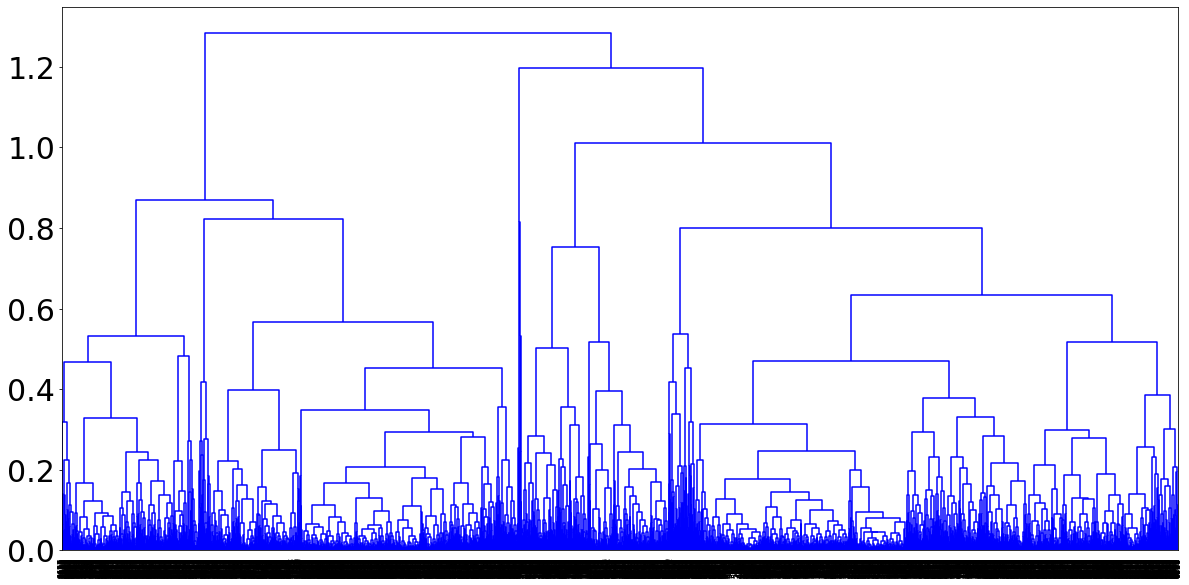

In [5]:
z = linkage(x,'complete')

plt.figure(figsize=(20,10))
den = dendrogram(z, labels = x.index ,
                 distance_sort= True,leaf_font_size = 8, color_threshold= 0)

In [6]:
# Funkcija za opisivanje klastera
def describe_clusters(df, features ,n): # n - broj klastera
    if 'labels' not in df.columns:
        print("Ne postoji kolona sa klasterima ili se drugacije naziva")
        return
    print(" ~ Opis dobijenih klastera: ~\n\n\n")
    
    for i in range(1,n+1):
        this_cluster = df.loc[ df['labels'] == i]
        num_of_members = len(this_cluster)
        if num_of_members == 0: # Ako se dogodi da imamo prazan klaster
            continue              # Nema potrebe ispisivati informacije o njemu
        print("********** Klaster {} : **********\n\n\n".format(i))
        print("Udeo: {} % ".format( int((num_of_members/whole_set) * 100) ) )
        print(" - Deskriptivne statistike: ")
        print(this_cluster.describe()[features])
        print("\n\n\n\n\n")

In [7]:

def model_agglomerative(z,x,df,t):
    df['labels'] = fcluster(z, t = t, criterion = 'distance')

    print("Dobijeni senka " + str(silhouette_score(x,df['labels'])))
    
    n = max(df['labels']) + 1
    describe_clusters(df=df,n=n-1, features = features)
    
    plt.figure(figsize= (20,10))
    for i in range(1,n):
        cluster = df[df['labels'] == i]
        plt.scatter(cluster['Longitude'], cluster['Latitude'], color = colors[i], label = "cluster %d"%i)

    plt.legend(loc = 2, prop = {'size' : 10})
    plt.show()

Dobijeni senka 0.43178506219699125
 ~ Opis dobijenih klastera: ~



********** Klaster 1 : **********



Udeo: 12 % 
 - Deskriptivne statistike: 
        Longitude    Latitude     Altitude
count  924.000000  924.000000   924.000000
mean   -71.606538   -7.882899   648.391775
std     27.819582   19.278091   910.775232
min   -179.876999  -67.567500     0.000000
25%    -76.655900  -22.496275    39.000000
50%    -66.910148   -8.057350   236.500000
75%    -55.964550    9.075769   871.250000
max    -32.423302   24.063299  6186.000000






********** Klaster 2 : **********



Udeo: 1 % 
 - Deskriptivne statistike: 
        Longitude   Latitude     Altitude
count   80.000000  80.000000    80.000000
mean   -96.067698  19.451196  7204.662500
std     16.096221  19.042955  1131.381691
min   -155.554001 -22.921700  5016.000000
25%   -106.999748   2.189863  6442.000000
50%   -101.760002  20.533899  7024.000000
75%    -78.456427  36.844001  7870.750000
max    -66.177101  44.688400  9840.000000








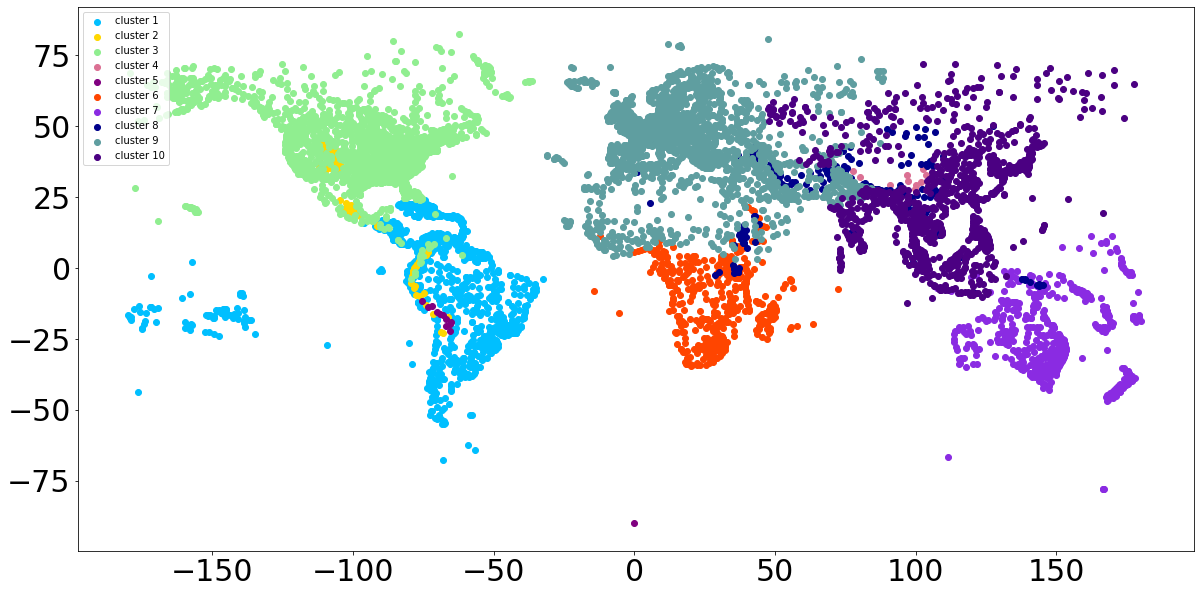

In [12]:
# Na osnovu dendograma, prvo 0.6 nam se čini kao najbolja opcija
model_agglomerative(z=z,x=x,df=df,t=0.6)

Dobijeni senka 0.3231936632357749


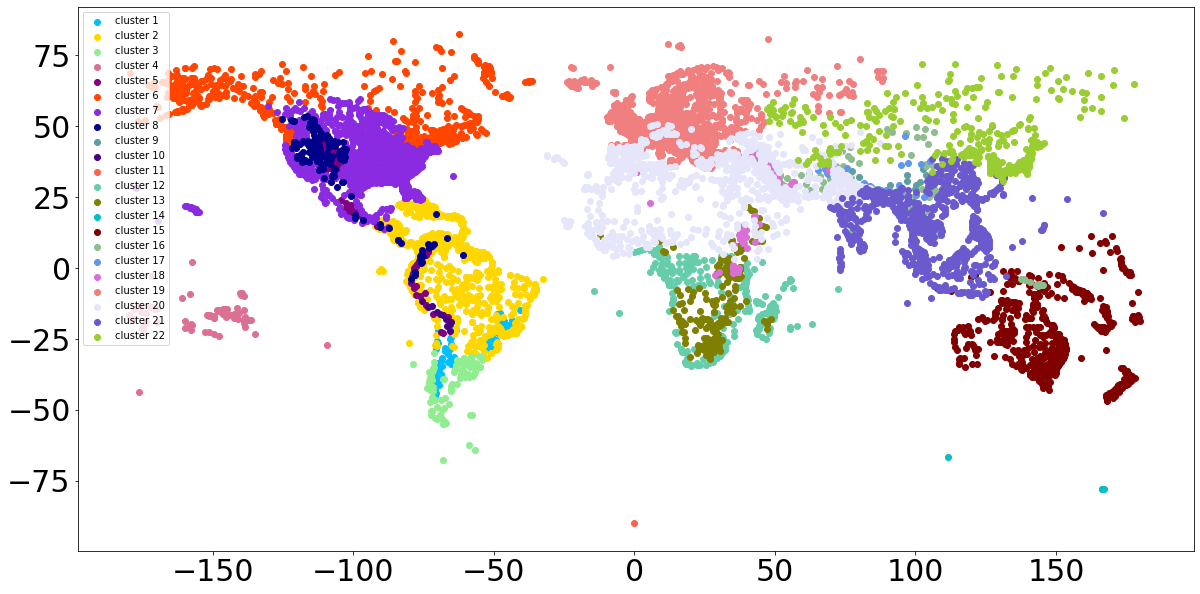

In [9]:
# I da vidimo kakav rezultat dobijamo za manji prag t
model_agglomerative(z=z,x=x,df=df,t=0.44)

### Analiza dosadašnjih rezultata i procene za dalje pokušaje

Ima malih klastera koji bi trebalo da budu deo velikih. Klasteri su međusobno isprepletani.


Dobijeni senka 0.37912851575057954


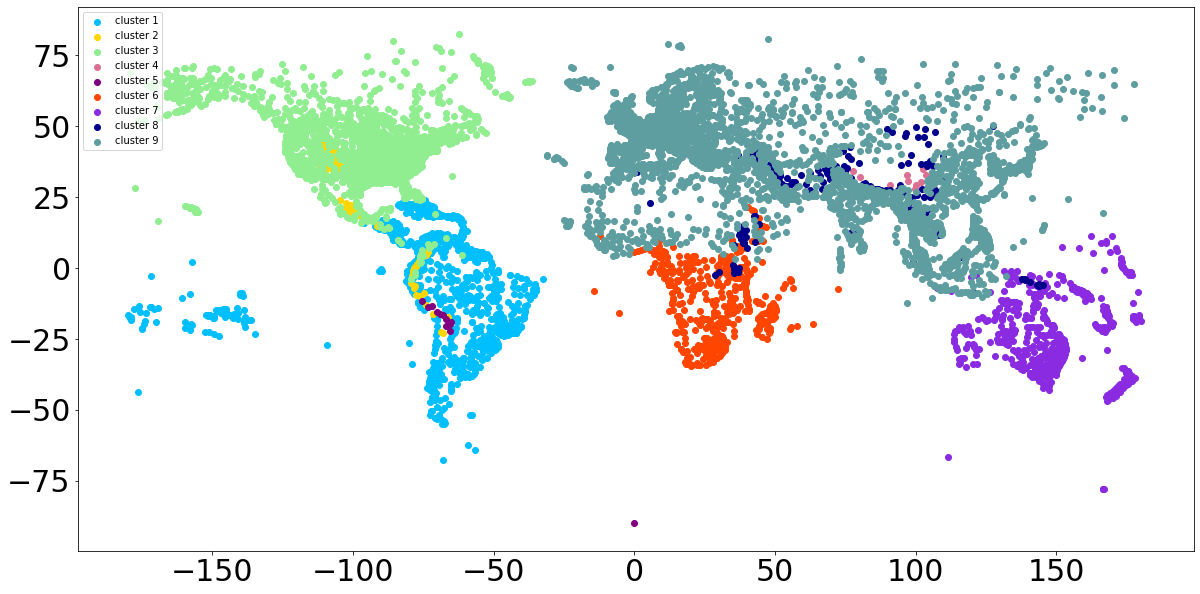

In [10]:
# Dalje pokušavamo, sad za veće vrednosti praga
model_agglomerative(z=z,df=df,x=x,t=0.64)

Dobijeni senka 0.37912851575057954


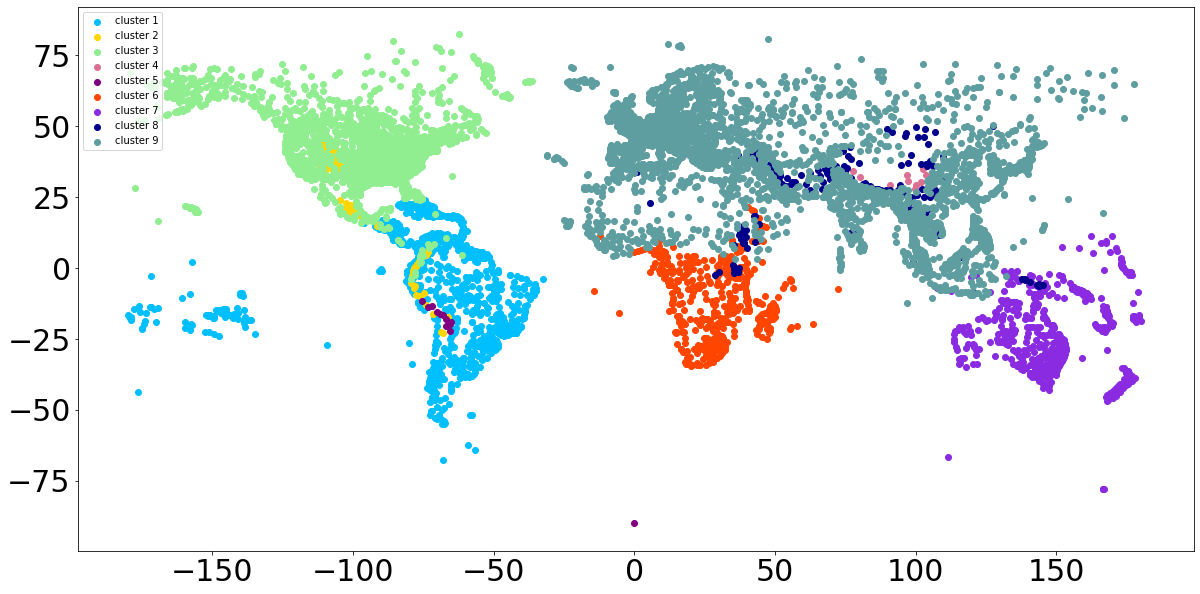

In [11]:
# Još povećavamo vrednost t
model_agglomerative(z=z,df=df,x=x,t=0.75)

Dobijeni senka 0.4098954040069277


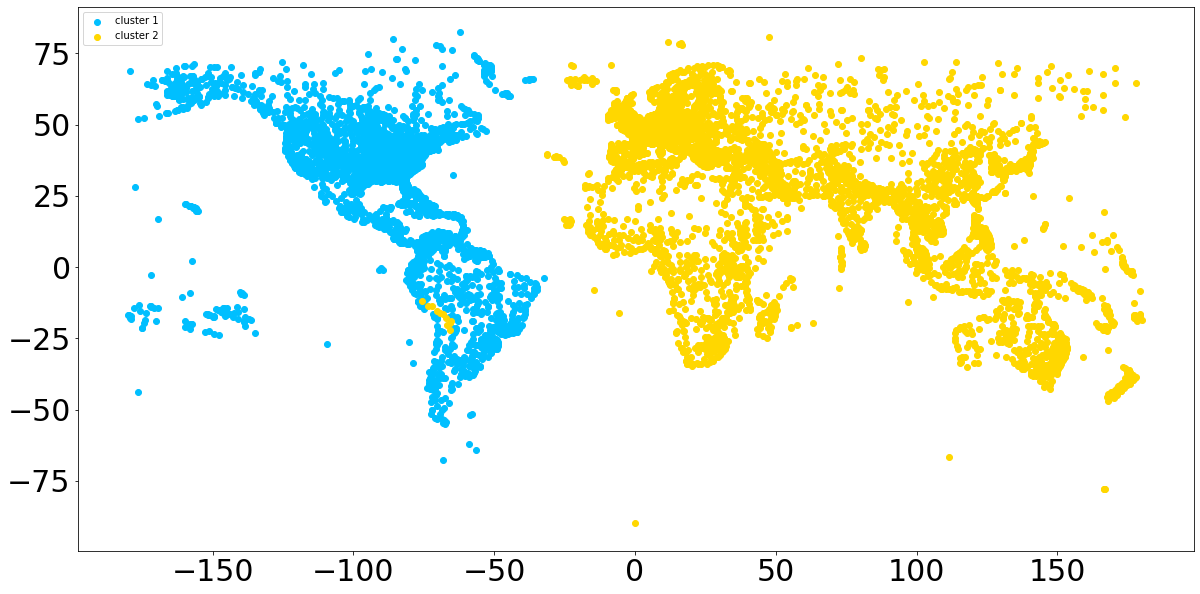

In [12]:
# Na kraju radi demonstracije, pusticemo za najvecu vrednost t = 1.2.
model_agglomerative(z=z,df=df,x=x,t=1.2)

S druge strane, za velike vrednosti praga su u 'obične' klastere obuhvaćeni i elementi van granica.

Sledeći kriterijum koji ćemo da probamo je prosečno rastojanje elemenata iz različitih klastera. Pravimo novu matricu rastojanja i novi dendogram, a koristićemo istu funkciju za formiranje klastera.

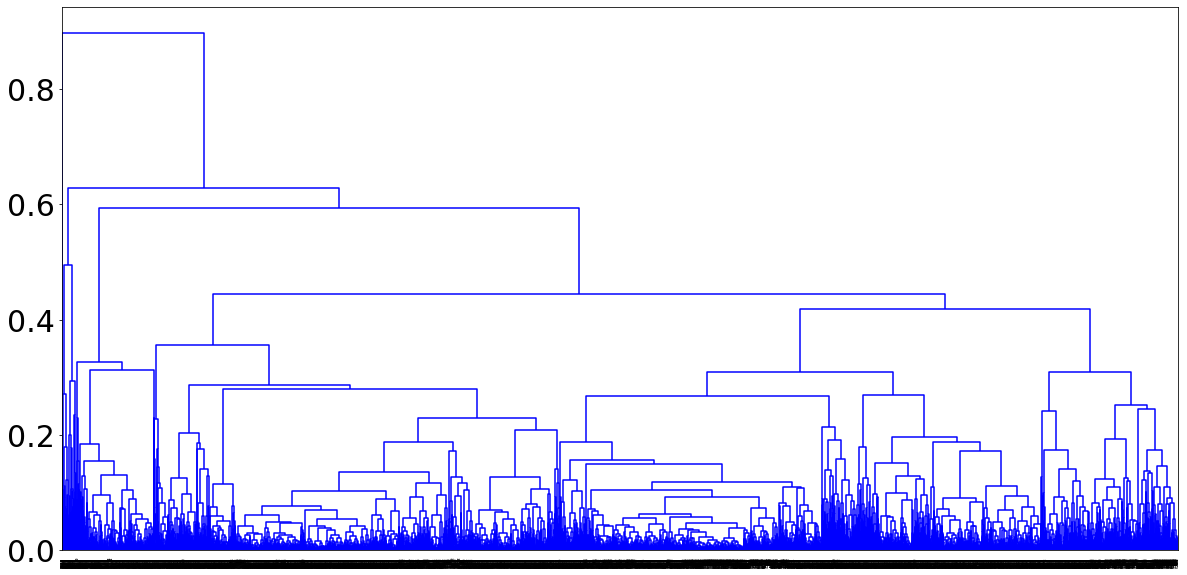

In [13]:
z = linkage(x,'average')

plt.figure(figsize= (20,10) )
den = dendrogram(z,labels = x.index, color_threshold=0, distance_sort= True, leaf_font_size= 4)

Dobijeni senka 0.3957119730069078


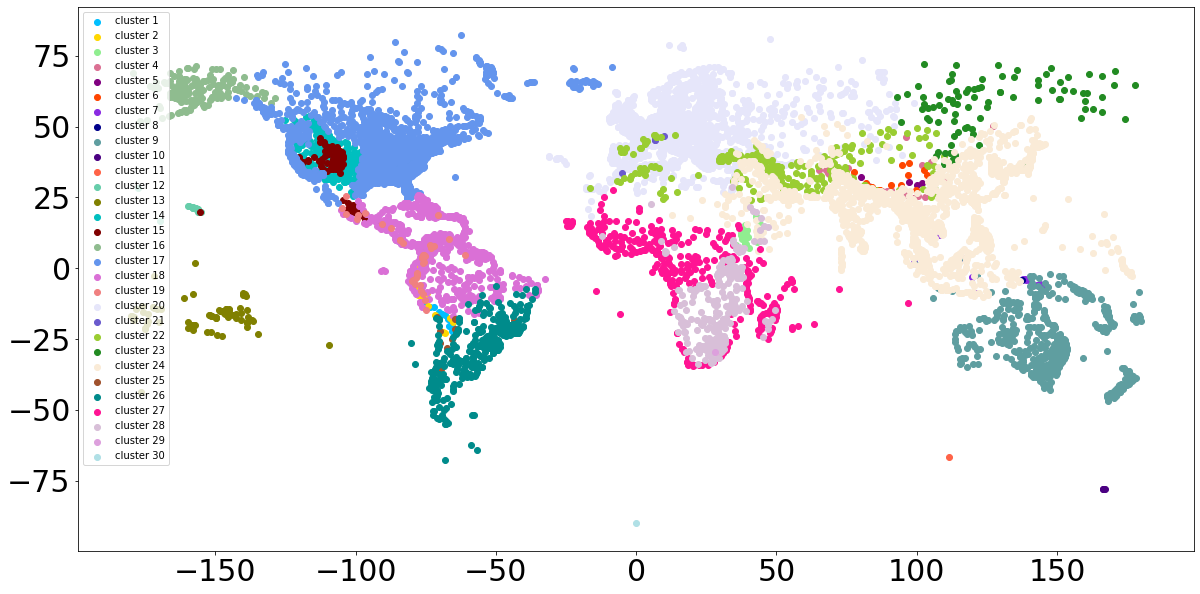

In [14]:
# Počećemo od manje vrednosti praga 
model_agglomerative(df=df,x=x,z=z,t=0.2)

Dobijeni senka 0.40373546433410723


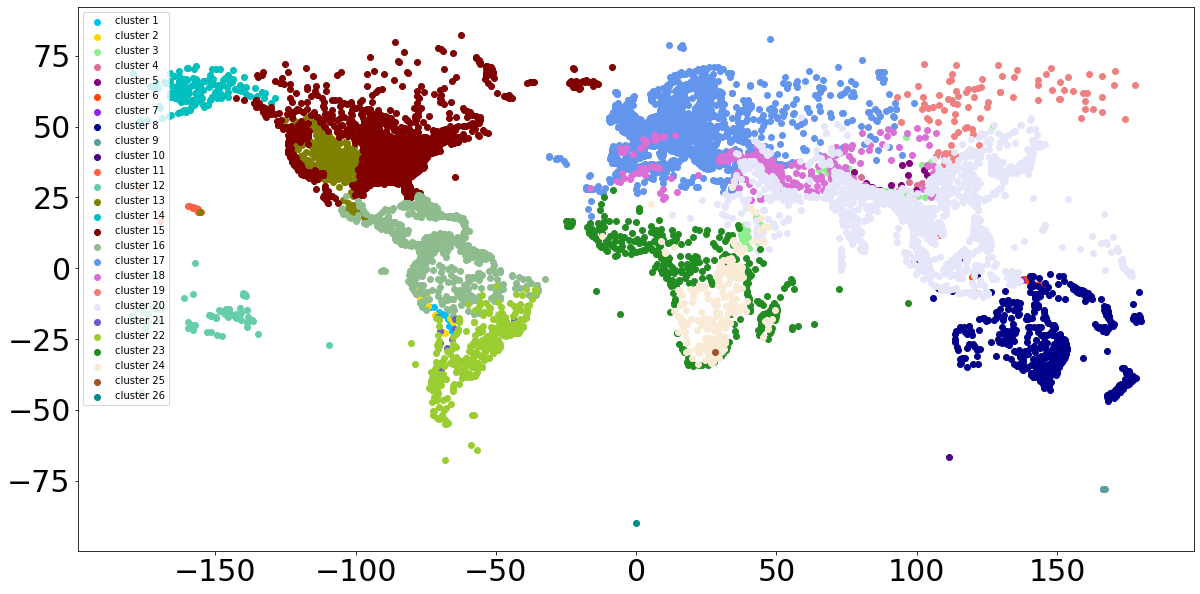

In [15]:
# Mnogo malih klastera u okviru velikih, međusobno isprepletani
model_agglomerative(df=df,x=x,z=z,t=0.22)

Dobijeni senka 0.4020917225602798


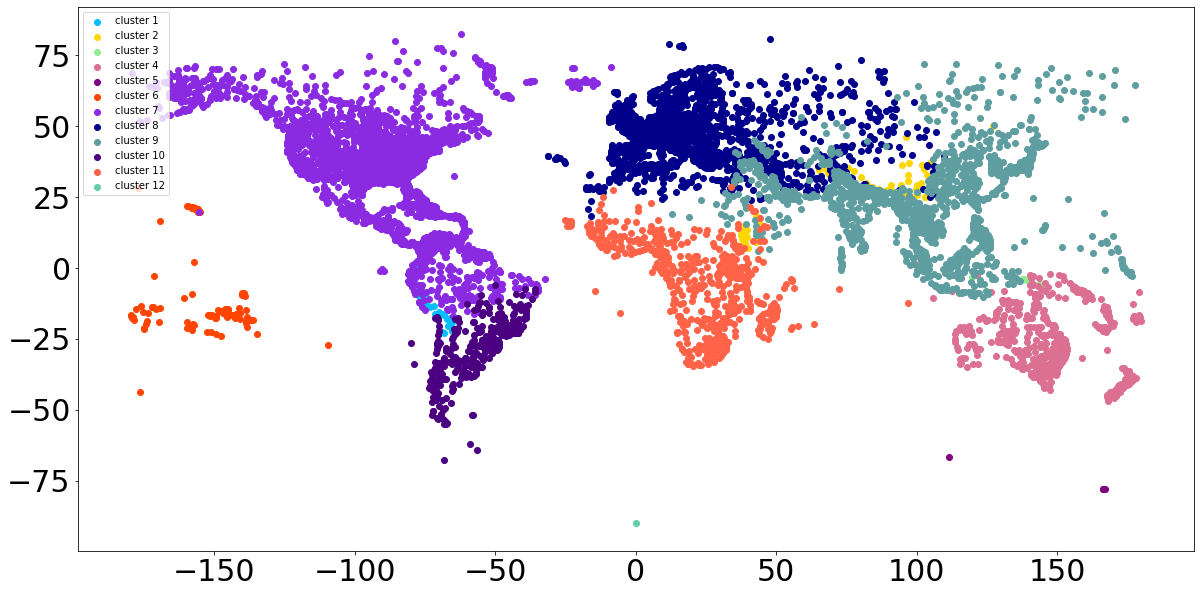

In [16]:
model_agglomerative(df=df,x=x,z=z,t=0.3)

Sad ćemo da pokušamo sa kriterijumom *Ward*-ove mere.

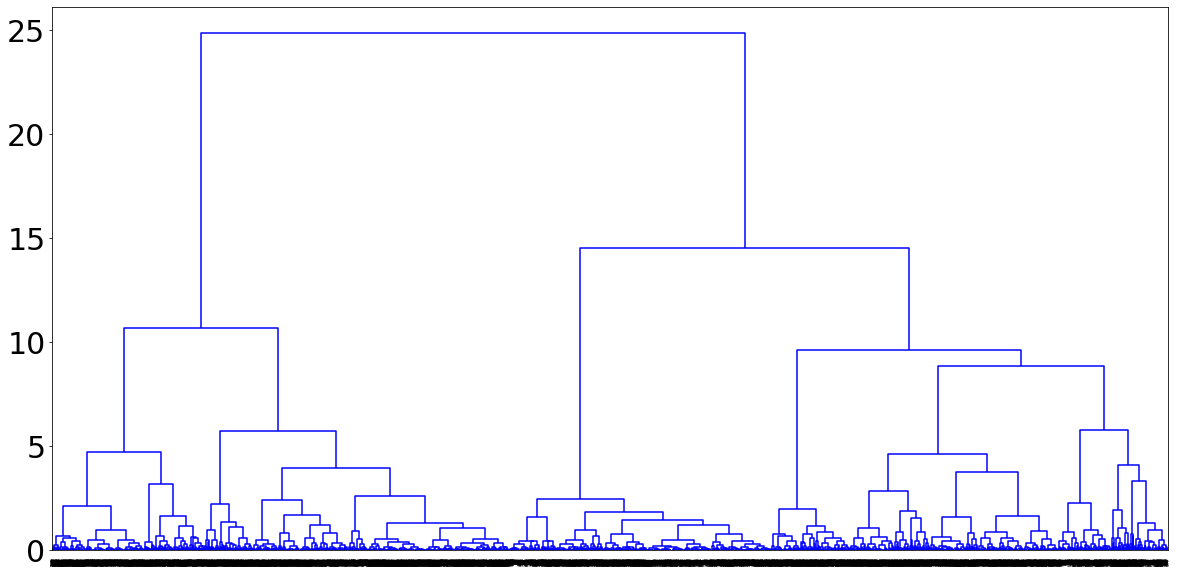

In [17]:
z = linkage(x,method = "ward")

plt.figure(figsize = (20,10))
den = dendrogram(z, labels = x.index,
                 color_threshold= 0 , distance_sort= True, leaf_font_size= 3)

Dobijeni senka 0.4071194784844695


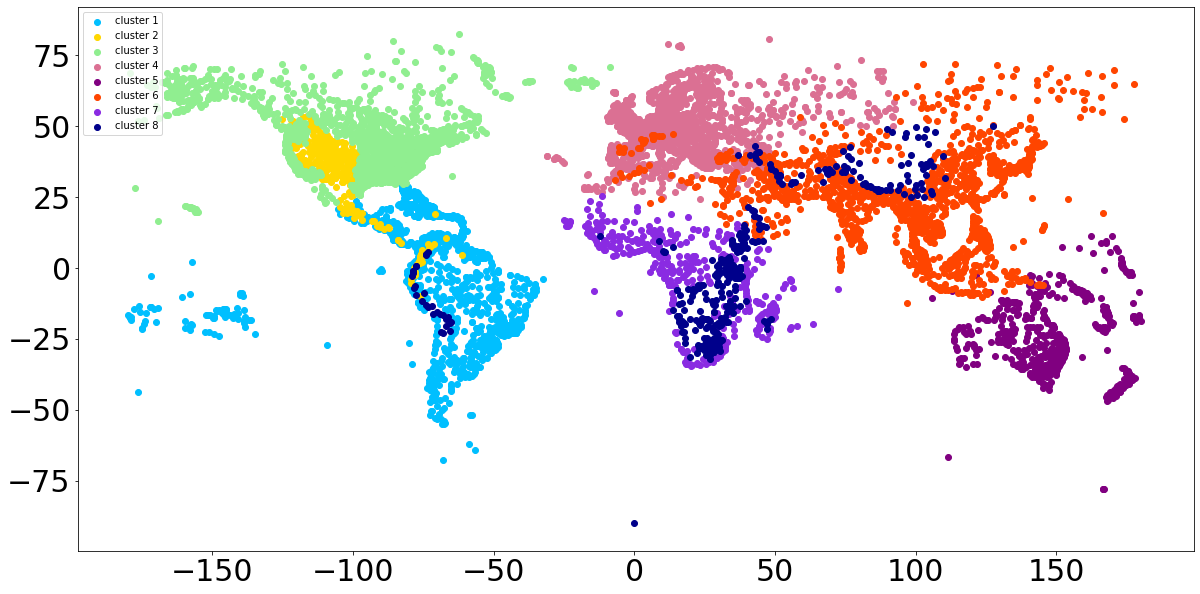

In [18]:
model_agglomerative(df=df,x=x,z=z,t= 5)

Dobijeni senka 0.4071194784844695


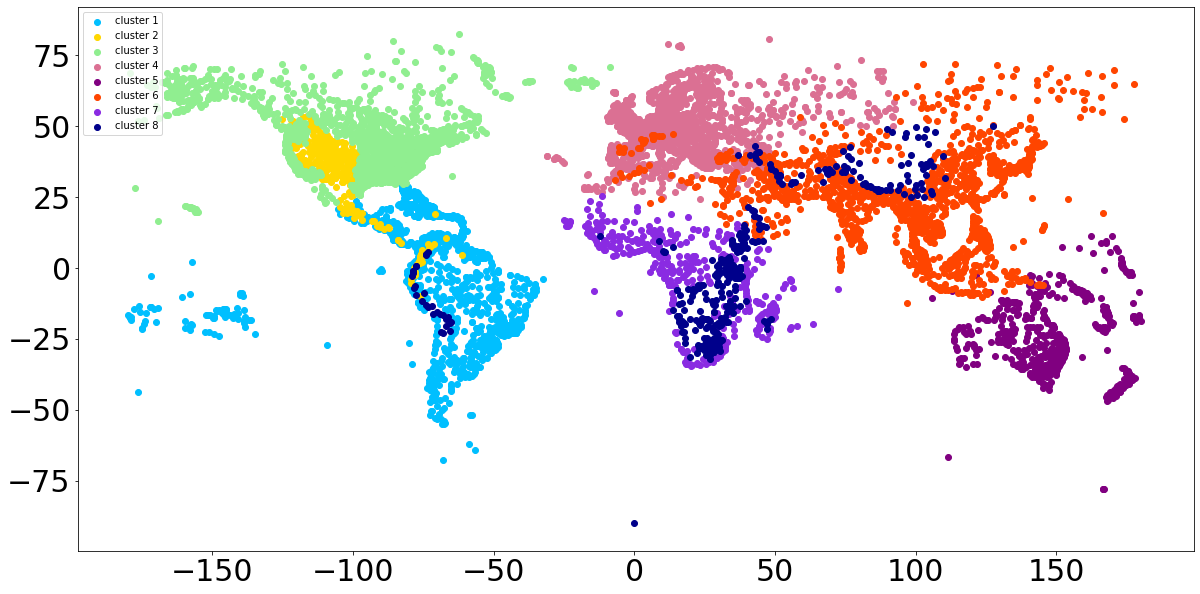

In [19]:
model_agglomerative(df=df,x=x,z=z,t= 5.3)

Na kraju ćemo ipak pokušati i sa kriterijumom Min - veze.

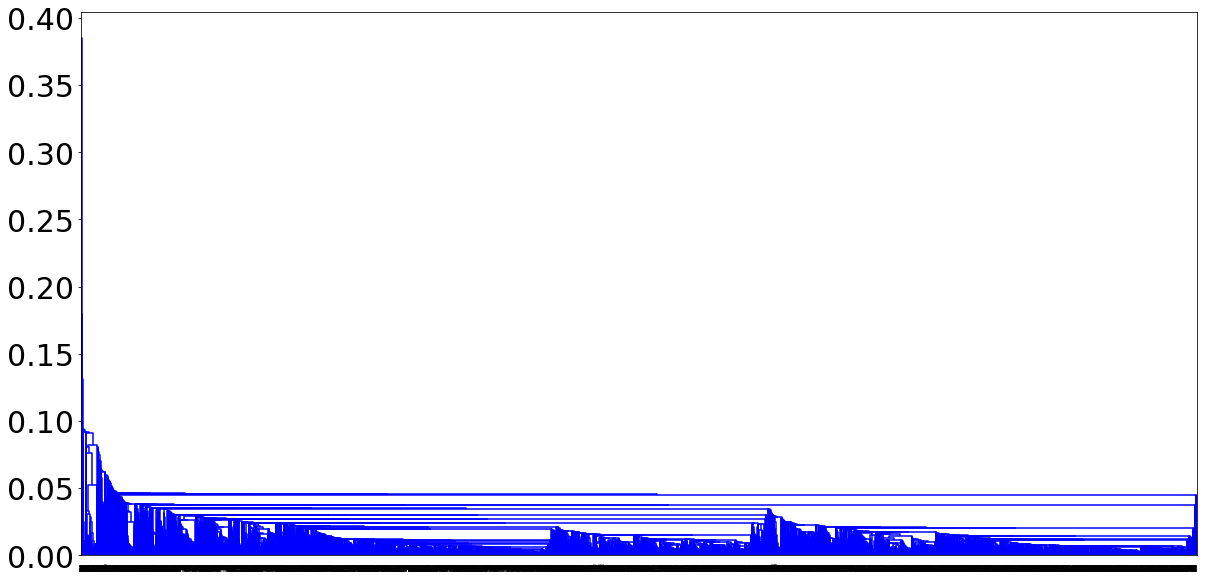

In [20]:
z = linkage(x,method = "single")

plt.figure(figsize = (20,10))
den = dendrogram(z, labels = x.index,
                 color_threshold= 0 , distance_sort= True, leaf_font_size= 3)

Sada i na osnovu dendograma možemo videti da, kao što smo na početku pretpostavili, nema mnogo smisla pokušavati sa Min - vezom. Ostavićemo primer jedne primene algoritma.

In [26]:
#model_agglomerative(df=df,x=x,z=z,t= 0.09)